In [47]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time
import os
from sklearn.preprocessing import LabelEncoder

In [48]:
import warnings; warnings.simplefilter('ignore')

In [71]:
np.random.seed(0)
df = pd.read_csv("../../Data/dataset2/train.csv")

df.dropna(inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)
drop_indices = np.random.choice(np.arange(0, df.shape[0], 1), 350, replace=False)
df.drop(drop_indices, inplace=True)
X = df.drop(columns=['price_range'])
y = df[['price_range']]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
df[['price_range']].value_counts()

price_range
1              419
0              417
2              416
3              398
dtype: int64

In [78]:
# preventing information about the distribution of the test set leaking into your model
standard_scaler = StandardScaler()
x_train_scaled = standard_scaler.fit_transform(x_train)
x_test_scaled = standard_scaler.fit_transform(x_test)
y_train_scaled = standard_scaler.fit_transform(y_train).astype('int')
y_test_scaled = standard_scaler.fit_transform(y_test).astype('int')

In [86]:
clf = MLPClassifier(random_state=1)
start_time = time.time()
clf.fit(x_train_scaled, [x[0] for x in y_train_scaled])
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test_scaled)
print(f"DT Normal Model: Fit Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred)}")
print(classification_report(y_test_scaled, y_pred))

DT Normal Model: Fit Time: 1.0053884983062744
DT Normal Model: Fit Time: 0.0007545948028564453
Score of Model Tree are (Mean Accuracy of test and train data): 0.9
              precision    recall  f1-score   support

          -1       0.91      0.91      0.91        88
           0       0.90      0.90      0.90       166
           1       0.89      0.88      0.89        76

    accuracy                           0.90       330
   macro avg       0.90      0.90      0.90       330
weighted avg       0.90      0.90      0.90       330



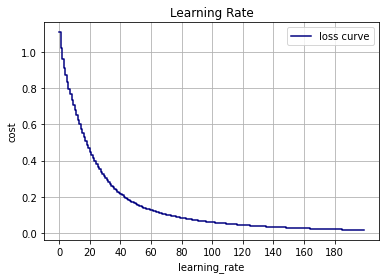

In [87]:
plt.plot(clf.loss_curve_, label="loss curve", color="navy", drawstyle="steps-post")
plt.title("Learning Rate")
plt.xlabel('learning_rate')
plt.ylabel('cost')
plt.grid()
plt.xticks(np.arange(0, len(clf.loss_curve_), 20))
plt.savefig(os.getcwd() + "/ann_learning_rate_price.png")
plt.legend()
plt.show()

In [97]:
# Initial Validation Curve
# Your MLP didn't converge: 
# The algorithm is optimizing by a stepwise convergence to a minimum and in run 1 your minimum wasn't found.
# depth_range = np.arange(20, 30) + 1
d = df.shape[1]
depth_range = [(h,)*l for l in [1,2,3] for h in [d,d//2,d*2]]
param = "hidden_layer_sizes"
classifier = "MLP Classifier"
train_scores, test_scores = validation_curve(clf, x_train, np.ravel(y_train), param_name=param, param_range=depth_range, cv=5)

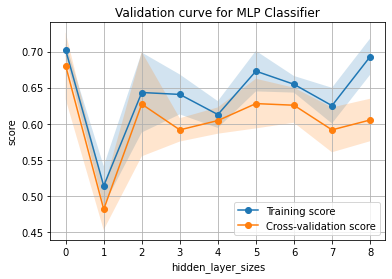

In [98]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = np.arange(0, len(depth_range), 1)
plt.figure()
plt.xticks(np.arange(0, len(depth_range)))
# plt.yticks(np.arange(0.60, 1.00, 0.01))
plt.plot(depth_range_list, mean_train_scores, 'o-', label='Training score')
plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/ann_validation_curve_price.png')
plt.show()

In [93]:
from sklearn.model_selection import cross_val_score
crossValScores = cross_val_score(clf, x_train, np.ravel(y_train), cv=5)
print("Cross Valuation Scores for unpruned tree are ", crossValScores)
print("Mean accuracy score is ", crossValScores.mean())
print("Std accuracy score is ", crossValScores.std())

Cross Valuation Scores for unpruned tree are  [0.64772727 0.625      0.62878788 0.60606061 0.62878788]
Mean accuracy score is  0.6272727272727272
Std accuracy score is  0.013252163397375671


In [94]:
print(classification_report(y_test, y_pred))
[(h,)*l for l in [1,2,3] for h in [d,d//2,d*2]]

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.05      0.09      0.06        88
           1       0.00      0.00      0.00        79
           2       0.00      0.00      0.00        87
           3       0.00      0.00      0.00        76

    accuracy                           0.02       330
   macro avg       0.01      0.02      0.01       330
weighted avg       0.01      0.02      0.02       330



[(21,),
 (10,),
 (42,),
 (21, 21),
 (10, 10),
 (42, 42),
 (21, 21, 21),
 (10, 10, 10),
 (42, 42, 42)]

In [95]:
print(confusion_matrix(y_test, y_pred))

[[ 0  0  0  0  0]
 [80  8  0  0  0]
 [ 8 71  0  0  0]
 [ 0 79  8  0  0]
 [ 0  9 67  0  0]]


In [96]:
# To make the results deterministic - we need to use random_state
pipelineA = Pipeline([('scaler', StandardScaler()), 
                      ('mlp', MLPClassifier(random_state=1))])
start_time = time.time()
p = pipelineA.fit(x_train, np.ravel(y_train))
print(f"MLP Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipelineA = p.predict(x_test)
print(f"MLP Pipeline Model: Predict Time: {time.time() - start_time}")

MLP Pipeline Model: Fit Time: 1.0222184658050537
MLP Pipeline Model: Predict Time: 0.002004861831665039


In [38]:
d = x_train.shape[1]
param = { 
         'mlp__alpha': [0.065, 0.075, 0.08, 0.090],
         'mlp__hidden_layer_sizes': [(h,)*l for l in [1,2,3] for h in [d,d//2,d*2]],
         'mlp__activation': ['relu', 'logistic', 'tanh'],
         'mlp__solver': ['adam', 'sgd', 'lbfgs'], 
         'mlp__learning_rate': ['constant', 'invscaling', 'adaptive']
        }
clf_cv = GridSearchCV(pipelineA, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True, verbose=4)
start_time = time.time()
clf_cv = clf_cv.fit(x_train, np.ravel(y_train))
print(f"MLP CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test)
print(f"MLP CV Model: Predict Time: {time.time() - start_time}")
clf_cv.best_params_

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 421 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1793 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 2258 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 2773 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 3949 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 4610 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 4860 out of 4860 | elapsed:   46.2s finished


MLP CV Model: Fit Time: 47.633739948272705
MLP CV Model: Predict Time: 0.004527091979980469


{'mlp__activation': 'logistic',
 'mlp__alpha': 0.09,
 'mlp__hidden_layer_sizes': (40, 40, 40),
 'mlp__learning_rate': 'constant',
 'mlp__solver': 'adam'}

In [39]:
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test, y_pred_pipeline_cv)}")
print(classification_report(np.ravel(y_test), y_pred_pipeline_cv))

Score of Model Tree are (Mean Accuracy of test and train data): 0.9757575757575757
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        88
           1       0.97      0.95      0.96        79
           2       0.99      0.98      0.98        87
           3       0.99      0.99      0.99        76

    accuracy                           0.98       330
   macro avg       0.98      0.98      0.98       330
weighted avg       0.98      0.98      0.98       330



In [40]:
sc_df = pd.DataFrame(clf_cv.cv_results_)
sc_df.dropna(inplace=True)
sc_df.sort_values(by="rank_test_score", ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__learning_rate,param_mlp__solver,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
645,1.944955,0.136205,0.003436,0.000636,logistic,0.09,"(40, 40, 40)",adaptive,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",...,0.967424,0.011638,1,0.981061,0.980114,0.982955,0.984848,0.983902,0.982576,0.001756
642,1.960587,0.036596,0.004061,0.000682,logistic,0.09,"(40, 40, 40)",invscaling,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",...,0.967424,0.011638,1,0.981061,0.980114,0.982955,0.984848,0.983902,0.982576,0.001756
639,2.006640,0.066676,0.004240,0.000653,logistic,0.09,"(40, 40, 40)",constant,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",...,0.967424,0.011638,1,0.981061,0.980114,0.982955,0.984848,0.983902,0.982576,0.001756
483,1.854818,0.121569,0.004450,0.002287,logistic,0.075,"(40, 40, 40)",adaptive,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",...,0.966667,0.011338,4,0.981061,0.980114,0.982955,0.986742,0.985795,0.983333,0.002583
564,1.914370,0.129001,0.003701,0.000652,logistic,0.08,"(40, 40, 40)",adaptive,adam,"{'mlp__activation': 'logistic', 'mlp__alpha': ...",...,0.966667,0.011338,4,0.981061,0.980114,0.982955,0.985795,0.985795,0.983144,0.002350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.452689,0.036249,0.003855,0.000753,relu,0.075,"(20,)",invscaling,sgd,"{'mlp__activation': 'relu', 'mlp__alpha': 0.07...",...,0.215152,0.033057,965,0.222538,0.214015,0.219697,0.199811,0.224432,0.216098,0.008871
733,0.199149,0.009024,0.003205,0.000327,tanh,0.075,"(20,)",invscaling,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.07...",...,0.212879,0.043215,969,0.227273,0.217803,0.223485,0.194129,0.215909,0.215720,0.011527
652,0.215106,0.024815,0.003599,0.000500,tanh,0.065,"(20,)",invscaling,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.06...",...,0.212879,0.043215,969,0.227273,0.217803,0.223485,0.194129,0.215909,0.215720,0.011527
814,0.195496,0.007748,0.003070,0.000275,tanh,0.08,"(20,)",invscaling,sgd,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.08...",...,0.212879,0.043215,969,0.227273,0.217803,0.223485,0.194129,0.215909,0.215720,0.011527


In [41]:
# Initial learning curve
train_sizes = np.arange(0.1, 1.0, 0.1)
cv_new = MLPClassifier(random_state=0, activation='logistic', alpha=0.09, hidden_layer_sizes= (40,40,40))
_, train_scores, test_scores = learning_curve(cv_new, x_train, np.ravel(y_train), train_sizes=train_sizes, cv=5)

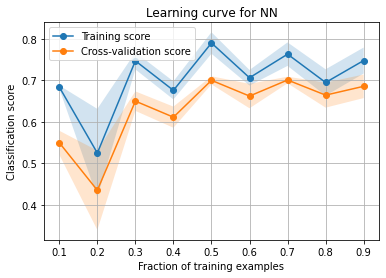

In [42]:
plt.figure()
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for NN')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/nn_learning_curve_price.png')
plt.show()

In [43]:
fit_time_list = []
predict_time_list = []
param = "hidden_layer_sizes"
param_list = [(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]
y_train = np.ravel(y_train)
clf_score_list = []
main_start_time = time.time()
for i in param_list:
    clf = MLPClassifier(hidden_layer_sizes=i)
    
    start_time = time.time()
    clf.fit(x_train_scaled, y_train)
    clf_score_list.append(clf.score(x_train_scaled, y_train))
    print(f"Clf score: {clf.score(x_train_scaled, y_train)}")
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
    
    start_time = time.time()
    y_pred = clf.predict(x_test_scaled)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
    
print(f"Entire cell took {time.time() - main_start_time}")

Clf score: 0.9825757575757575
Clf score: 0.9643939393939394
Clf score: 0.9946969696969697
Clf score: 1.0
Clf score: 0.9886363636363636
Clf score: 1.0
Clf score: 1.0
Clf score: 0.996969696969697
Clf score: 1.0
Clf score: 1.0
Clf score: 1.0
Clf score: 1.0
Clf score: 1.0
Clf score: 0.9954545454545455
Clf score: 1.0
Entire cell took 11.830772876739502


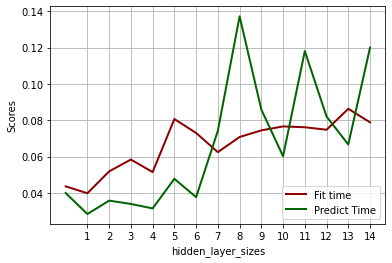

In [45]:
def normalize_data_points(points):
    return [float(i)/sum(points) for i in points]

lw = 2
param_list = np.arange(0, len([(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]))
plt.plot(param_list, normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(param_list, normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)
plt.xlabel(param)
plt.ylabel("Scores")
plt.xticks(np.arange(1, len(param_list), 1.0))
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() + '/nn_fit_vs_predict_price.png')

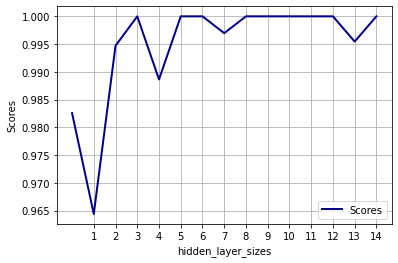

In [46]:
lw = 2
param_list = np.arange(0, len([(h,)*l for l in [1,2,3,4,5] for h in [d,d//2,d*2]]))
plt.plot(param_list, clf_score_list, label="Scores", color="darkblue", lw=lw)
plt.xlabel(param)
plt.ylabel("Scores")
plt.xticks(np.arange(1, len(param_list), 1.0))
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() + '/nn_hidden_layers_vs_score_price.png')